In [21]:
# !pip install pandas
# !pip install statsmodels
# !pip install matplotlib
# !pip install skforecast
#!pip install seaborn


## Importación Librerias

In [108]:
import pandas as pd
import requests
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import calendar
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from skforecast.model_selection import grid_search_forecaster
from datetime import datetime
from sklearn import metrics  # Para scikit-learn
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer

## Importación bases cliente

In [23]:
# URL del repositorio en GitHub
repo_url = 'https://api.github.com/repos/Pacheco-Carvajal/GPA-Data-ElectroDunas/contents/'

# Haz una solicitud GET a la API de GitHub para obtener la lista de archivos en el directorio
response = requests.get(repo_url)
file_data = response.json()

# Filtra los archivos que contienen "datos cliente" en su nombre
desired_files = [(file['download_url'], file['name']) for file in file_data if 'DATOSCLIENTE' in file['name']]

# Crea un DataFrame combinando todos los archivos encontrados
dfs = []
for file_url, file_name in desired_files:
    response = requests.get(file_url)
    content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(content))

    # Agrega una columna "fuente" con el nombre del archivo
    df['fuente'] = file_name

    dfs.append(df)

# Concatena los DataFrames en uno solo
result_df = pd.concat(dfs, ignore_index=True)

## Importación sector clientes

In [24]:
# URL cruda del archivo en GitHub
url = "https://github.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/raw/main/sector_economico_clientes.xlsx"

# Cargar el archivo Excel en un DataFrame
sectores = pd.read_excel(url)

# Mostrar las primeras filas del DataFrame
sectores.head()

,Cliente:,Sector Económico:
0,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,Cliente 2,Elaboración de cacao y chocolate y de producto...
2,Cliente 3,Elaboración de cacao y chocolate y de producto...
3,Cliente 4,Elaboración de cacao y chocolate y de producto...
4,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [25]:
# Extraer los números de la columna 'fuente'
result_df['fuente'] = result_df['fuente'].str.extract('(\d+)')

# Concatenar 'Cliente' con los números extraídos
result_df['fuente'] = 'Cliente ' + result_df['fuente']

result_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\johan\AppData\Local\Temp\ipykernel_2368\2501991270.py:2: SyntaxWarning: invalid escape sequence '\d'
  result_df['fuente'] = result_df['fuente'].str.extract('(\d+)')


,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,fuente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1


In [26]:
result_df = result_df.rename(columns={'fuente': 'Cliente'})
sectores = sectores.rename(columns={'Cliente:': 'Cliente'})
sectores['Cliente'] = sectores['Cliente'].str.strip()

In [27]:
result_df = pd.merge(result_df, sectores[['Cliente', 'Sector Económico:']], on='Cliente', how='left')
result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...


In [28]:
result_df = result_df.rename(columns={'Sector Económico:': 'Sector Económico'})
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])
result_df['Active_energy'] = result_df['Active_energy'].apply(lambda x: 0 if x < 0 else x)

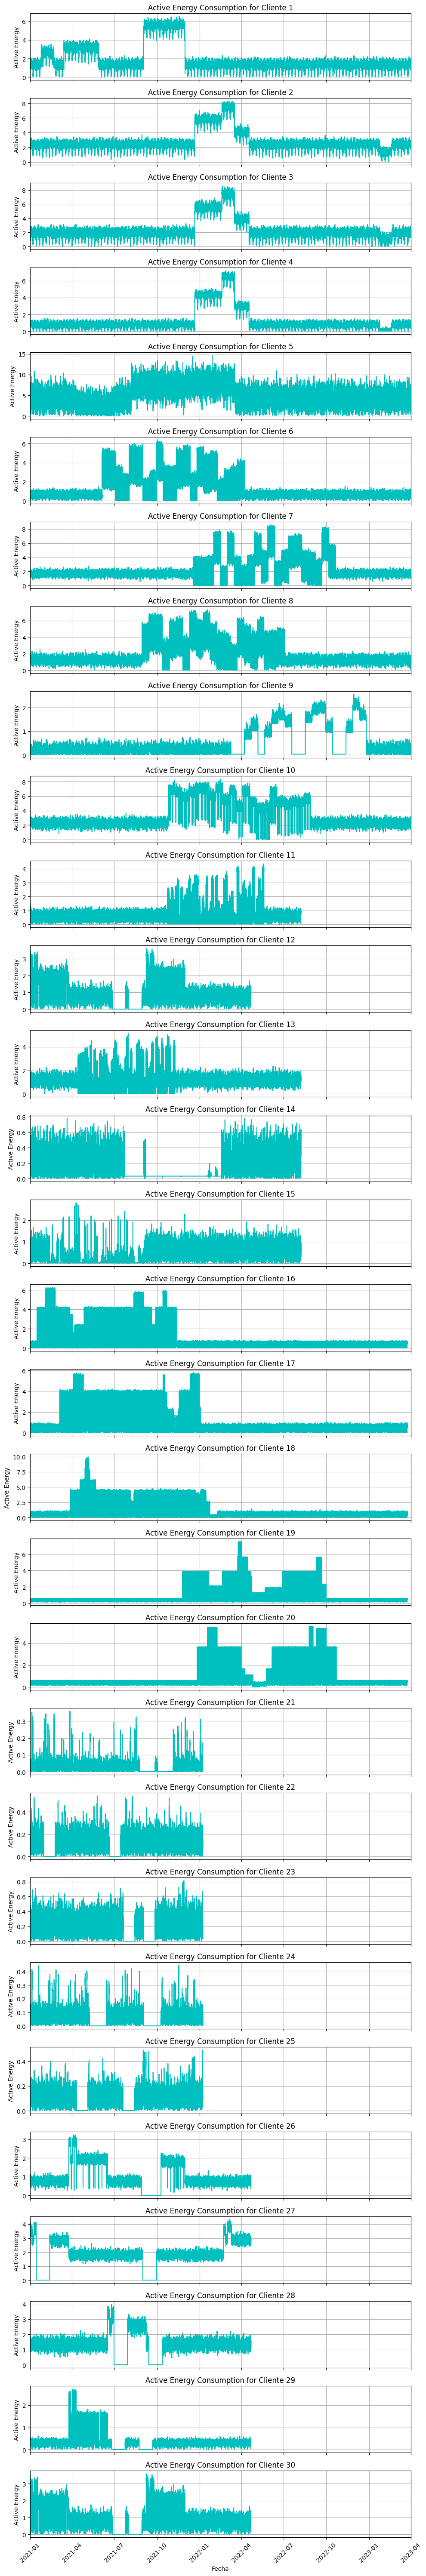

In [29]:
# Suponiendo que 'result_df' es tu DataFrame y ya está cargado correctamente
# Asegúrate de que 'Fecha' está en formato de fecha si no está convertido aún
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])

# Encuentra los límites del eje x para todos los subplots
fecha_min = result_df['Fecha'].min()
fecha_max = result_df['Fecha'].max()

# Preparar la figura y los ejes
fig, axes = plt.subplots(nrows=30, ncols=1, figsize=(10, 60), sharex=True)  # 30 gráficos, uno por cada cliente

# Iterar sobre cada uno de los clientes
for i, cliente in enumerate(sorted(result_df['Cliente'].unique(), key=lambda x: int(x.split()[1])), start=0):
    # Filtrar el DataFrame por cliente
    df_temp = result_df[result_df['Cliente'] == cliente]
    
    # Trama en el subplot correspondiente
    ax = axes[i]
    ax.plot(df_temp['Fecha'], df_temp['Active_energy'], label=f'{cliente}', color='c')
    ax.set_title(f'Active Energy Consumption for {cliente}')
    ax.set_ylabel('Active Energy')
    ax.grid(True)

# Ajustar el eje x para mostrar fechas adecuadamente
axes[-1].set_xlim([fecha_min, fecha_max])  # Ajusta el eje x en el último subplot, que se aplica a todos
axes[-1].set_xlabel('Fecha')
plt.xticks(rotation=45)
plt.tight_layout()  # Optimizar el espaciado entre gráficos

# Mostrar el gráfico
plt.show()


## Selección de cliente a trabajar

In [30]:
numero_cliente = 5
cliente = 'Cliente '+ str(numero_cliente)
result_df[result_df['Cliente']==cliente]



,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico
365020,2021-01-01 00:00:00,4.457443,0.980230,746.016908,709.999466,Cliente 5,Elaboración de cacao y chocolate y de producto...
365021,2021-01-01 01:00:00,4.698414,4.057734,595.329779,679.061180,Cliente 5,Elaboración de cacao y chocolate y de producto...
365022,2021-01-01 02:00:00,3.228533,3.556386,669.818274,646.135216,Cliente 5,Elaboración de cacao y chocolate y de producto...
365023,2021-01-01 03:00:00,2.138653,3.800049,627.849139,656.165111,Cliente 5,Elaboración de cacao y chocolate y de producto...
365024,2021-01-01 04:00:00,2.827120,2.771083,652.307767,580.942897,Cliente 5,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
384696,2023-03-31 20:00:00,1.351702,5.776986,732.401034,730.731044,Cliente 5,Elaboración de cacao y chocolate y de producto...
384697,2023-03-31 21:00:00,4.803313,3.538812,576.031590,728.442563,Cliente 5,Elaboración de cacao y chocolate y de producto...
384698,2023-03-31 22:00:00,3.203953,5.504941,690.693389,691.430843,Cliente 5,Elaboración de cacao y chocolate y de producto...
384699,2023-03-31 23:00:00,3.330649,2.379746,603.184318,663.736458,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [31]:
cliente_df = result_df[result_df['Cliente'] == cliente].copy()
cliente_df

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico
365020,2021-01-01 00:00:00,4.457443,0.980230,746.016908,709.999466,Cliente 5,Elaboración de cacao y chocolate y de producto...
365021,2021-01-01 01:00:00,4.698414,4.057734,595.329779,679.061180,Cliente 5,Elaboración de cacao y chocolate y de producto...
365022,2021-01-01 02:00:00,3.228533,3.556386,669.818274,646.135216,Cliente 5,Elaboración de cacao y chocolate y de producto...
365023,2021-01-01 03:00:00,2.138653,3.800049,627.849139,656.165111,Cliente 5,Elaboración de cacao y chocolate y de producto...
365024,2021-01-01 04:00:00,2.827120,2.771083,652.307767,580.942897,Cliente 5,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
384696,2023-03-31 20:00:00,1.351702,5.776986,732.401034,730.731044,Cliente 5,Elaboración de cacao y chocolate y de producto...
384697,2023-03-31 21:00:00,4.803313,3.538812,576.031590,728.442563,Cliente 5,Elaboración de cacao y chocolate y de producto...
384698,2023-03-31 22:00:00,3.203953,5.504941,690.693389,691.430843,Cliente 5,Elaboración de cacao y chocolate y de producto...
384699,2023-03-31 23:00:00,3.330649,2.379746,603.184318,663.736458,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [32]:
# Ordenar los datos por fecha de manera ascendente
cliente_df = cliente_df.sort_values(by='Fecha')

In [33]:
# Seleccionar solo las columnas numéricas
columnas_numericas = cliente_df.select_dtypes(include=['int', 'float'])

# Calcular las correlaciones entre las variables numéricas
correlaciones = columnas_numericas.corr()

# Mostrar las correlaciones
print(correlaciones)


                 Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC
Active_energy         1.000000         0.153794   -0.064120   -0.062137
Reactive_energy       0.153794         1.000000   -0.014966   -0.016807
Voltaje_FA           -0.064120        -0.014966    1.000000    0.917182
Voltaje_FC           -0.062137        -0.016807    0.917182    1.000000


In [34]:
## Metricas de evaluación a emplear

In [35]:
def evaluacion_metrica(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

### Construcción base a modelar

In [36]:
data_completa = cliente_df[['Fecha','Active_energy']]
Frecuencia_horas = '12H'

In [37]:
data_completa.set_index('Fecha', inplace=True)

# Resample los datos cada 3 horas y sumar la energía activa
data_completa_diaria = data_completa.resample(Frecuencia_horas).sum()

# Si deseas resetear el índice para que 'Fecha' sea nuevamente una columna
data_completa_diaria.reset_index(inplace=True)

# Ver el DataFrame resultante
data_completa_diaria

,Fecha,Active_energy
0,2021-01-01 00:00:00,45.012793
1,2021-01-01 12:00:00,49.435851
2,2021-01-02 00:00:00,50.722687
3,2021-01-02 12:00:00,56.317324
4,2021-01-03 00:00:00,47.135008
...,...,...
1636,2023-03-30 00:00:00,49.610017
1637,2023-03-30 12:00:00,55.783393
1638,2023-03-31 00:00:00,56.871019
1639,2023-03-31 12:00:00,46.117800


In [38]:
data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour
data_completa_diaria.set_index('Fecha', inplace=True)
data_completa_diaria.index.freq = Frecuencia_horas
data_completa_diaria

,Active_energy,Month,Hour
Fecha,,,
2021-01-01 00:00:00,45.012793,1,0
2021-01-01 12:00:00,49.435851,1,12
2021-01-02 00:00:00,50.722687,1,0
2021-01-02 12:00:00,56.317324,1,12
2021-01-03 00:00:00,47.135008,1,0
...,...,...,...
2023-03-30 00:00:00,49.610017,3,0
2023-03-30 12:00:00,55.783393,3,12
2023-03-31 00:00:00,56.871019,3,0


In [39]:
data_completa = data_completa_diaria.copy()

In [40]:
data_completa['Active_energy_diff'] = data_completa['Active_energy'].diff()
data_completa = data_completa.dropna()
data_completa

,Active_energy,Month,Hour,Active_energy_diff
Fecha,,,,
2021-01-01 12:00:00,49.435851,1,12,4.423058
2021-01-02 00:00:00,50.722687,1,0,1.286836
2021-01-02 12:00:00,56.317324,1,12,5.594638
2021-01-03 00:00:00,47.135008,1,0,-9.182317
2021-01-03 12:00:00,54.532120,1,12,7.397112
...,...,...,...,...
2023-03-30 00:00:00,49.610017,3,0,-4.886475
2023-03-30 12:00:00,55.783393,3,12,6.173376
2023-03-31 00:00:00,56.871019,3,0,1.087626


In [41]:
n_rezagos_nivel = 30
for i in range(1, n_rezagos_nivel):#Rezagos del nivel
    data_completa[f'L{i}'] = data_completa['Active_energy'].shift(i)
    
n_rezagos_diferencia = 30
for i in range(1, n_rezagos_diferencia):#Rezagos de la diferencia
    data_completa[f'L{i}_diff'] = data_completa['Active_energy_diff'].shift(i)

data_completa.drop(columns=['Active_energy_diff'], inplace=True) #Se elimina la diferencia original
data_completa = data_completa.dropna()
data_completa

,Active_energy,Month,Hour,L1,L2,L3,L4,L5,L6,L7,...,L20_diff,L21_diff,L22_diff,L23_diff,L24_diff,L25_diff,L26_diff,L27_diff,L28_diff,L29_diff
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-01-16 00:00:00,60.631889,1,0,66.104962,53.257416,44.651658,37.859007,36.794928,52.092075,51.554936,...,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638,1.286836,4.423058
2021-01-16 12:00:00,59.815257,1,12,60.631889,66.104962,53.257416,44.651658,37.859007,36.794928,52.092075,...,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638,1.286836
2021-01-17 00:00:00,45.619522,1,0,59.815257,60.631889,66.104962,53.257416,44.651658,37.859007,36.794928,...,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638
2021-01-17 12:00:00,60.977079,1,12,45.619522,59.815257,60.631889,66.104962,53.257416,44.651658,37.859007,...,-5.468865,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317
2021-01-18 00:00:00,49.180185,1,0,60.977079,45.619522,59.815257,60.631889,66.104962,53.257416,44.651658,...,15.189525,-5.468865,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 00:00:00,49.610017,3,0,54.496492,61.465362,59.525148,65.923621,66.929454,50.334115,54.746687,...,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424,-4.865831,6.722735
2023-03-30 12:00:00,55.783393,3,12,49.610017,54.496492,61.465362,59.525148,65.923621,66.929454,50.334115,...,-0.391123,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424,-4.865831
2023-03-31 00:00:00,56.871019,3,0,55.783393,49.610017,54.496492,61.465362,59.525148,65.923621,66.929454,...,0.378572,-0.391123,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424


## División Base campos dependietes e Independientes y partición en datos de entrenamiento y test

In [42]:
X2= data_completa.iloc[:,1:]
X2

,Month,Hour,L1,L2,L3,L4,L5,L6,L7,L8,...,L20_diff,L21_diff,L22_diff,L23_diff,L24_diff,L25_diff,L26_diff,L27_diff,L28_diff,L29_diff
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-01-16 00:00:00,1,0,66.104962,53.257416,44.651658,37.859007,36.794928,52.092075,51.554936,62.300875,...,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638,1.286836,4.423058
2021-01-16 12:00:00,1,12,60.631889,66.104962,53.257416,44.651658,37.859007,36.794928,52.092075,51.554936,...,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638,1.286836
2021-01-17 00:00:00,1,0,59.815257,60.631889,66.104962,53.257416,44.651658,37.859007,36.794928,52.092075,...,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638
2021-01-17 12:00:00,1,12,45.619522,59.815257,60.631889,66.104962,53.257416,44.651658,37.859007,36.794928,...,-5.468865,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317
2021-01-18 00:00:00,1,0,60.977079,45.619522,59.815257,60.631889,66.104962,53.257416,44.651658,37.859007,...,15.189525,-5.468865,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 00:00:00,3,0,54.496492,61.465362,59.525148,65.923621,66.929454,50.334115,54.746687,51.362933,...,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424,-4.865831,6.722735
2023-03-30 12:00:00,3,12,49.610017,54.496492,61.465362,59.525148,65.923621,66.929454,50.334115,54.746687,...,-0.391123,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424,-4.865831
2023-03-31 00:00:00,3,0,55.783393,49.610017,54.496492,61.465362,59.525148,65.923621,66.929454,50.334115,...,0.378572,-0.391123,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424


In [43]:
Y2= data_completa.iloc[:,0]
Y2

Fecha
2021-01-16 00:00:00    60.631889
2021-01-16 12:00:00    59.815257
2021-01-17 00:00:00    45.619522
2021-01-17 12:00:00    60.977079
2021-01-18 00:00:00    49.180185
                         ...    
2023-03-30 00:00:00    49.610017
2023-03-30 12:00:00    55.783393
2023-03-31 00:00:00    56.871019
2023-03-31 12:00:00    46.117800
2023-04-01 00:00:00     5.812355
Freq: 12H, Name: Active_energy, Length: 1611, dtype: float64

In [44]:
# Calcular el índice que divide los datos en 70% de entrenamiento y 30% de prueba
traintarget_size = int(0.8 * len(Y2))

traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observaciones para el objetivo: %d' % (len(Y2)))
print('Observaciones de entrenamiento para el objetivo: %d' % (len(train_target)))
print('Observaciones de prueba para el objetivo: %d' % (len(test_target)))

Observaciones para el objetivo: 1611
Observaciones de entrenamiento para el objetivo: 1288
Observaciones de prueba para el objetivo: 323


In [45]:

trainfeature_size = int(len(X2) * 0.80)
train_feature, test_feature = X2[0:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observaciones para la característica: %d' % (len(X2)))
print('Observaciones de entrenamiento para la característica: %d' % (len(train_feature)))
print('Observaciones de prueba para la característica: %d' % (len(test_feature)))

Observaciones para la característica: 1611
Observaciones de entrenamiento para la característica: 1288
Observaciones de prueba para la característica: 323


## Pruebas estacionariedad para MODEL- BASED

In [46]:
for cliente_id in range(1, 31): 
    # Filtrar el DataFrame para obtener solo las filas correspondientes a este cliente
    cliente_data = result_df[result_df['Cliente'] == f'Cliente {cliente_id}']
    
    # Aplicar la prueba de estacionariedad (ADF) a la serie temporal
    resultado_prueba = adfuller(cliente_data['Active_energy'])
    
    # Resultados de la prueba
    print(f"Cliente {cliente_id}:")
    print("Estadística ADF:", resultado_prueba[0])
    print("Valor p:", resultado_prueba[1])
    print("Valores críticos:", resultado_prueba[4])
    print("Conclusion:", "Los datos son estacionarios." if resultado_prueba[1] < 0.05 else "Los datos no son estacionarios.")
    print()

Cliente 1:
Estadística ADF: -4.174790013551806
Valor p: 0.0007267220985626516
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 2:
Estadística ADF: -4.491405477319589
Valor p: 0.00020379220684839955
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 3:
Estadística ADF: -4.301114208378333
Valor p: 0.00044224295856500826
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 4:
Estadística ADF: -3.222778636035411
Valor p: 0.018703448324354662
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 5:
Estadística ADF: -4.787967121562019
Valor p: 5.734300303256207e-05
Valores críticos: {'1%': -3.430683086

## Modelo Random Forest inicial

In [47]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr = RandomForestRegressor(n_estimators=500,n_jobs=-1)

# Entrenamos el modelo
rfr.fit(train_feature, train_target)

# Hacemos las predicciones 
fcst = rfr.predict(test_feature)

In [48]:
b=pd.DataFrame({"Actual":test_target, "Random Forest":fcst})
b

,Actual,Random Forest
Fecha,,
2022-10-22 00:00:00,43.452680,43.339420
2022-10-22 12:00:00,33.054786,46.149559
2022-10-23 00:00:00,44.379023,43.894218
2022-10-23 12:00:00,51.204228,47.088019
2022-10-24 00:00:00,62.034365,55.623018
...,...,...
2023-03-30 00:00:00,49.610017,52.157072
2023-03-30 12:00:00,55.783393,53.053464
2023-03-31 00:00:00,56.871019,52.963324


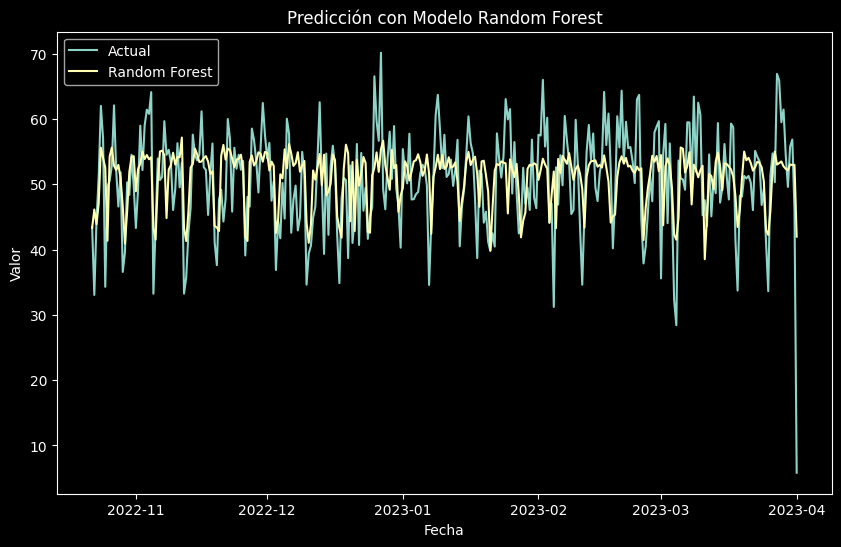

In [49]:
# Configurando el estilo oscuro similar al 'plotly_dark'
plt.style.use('dark_background')

# Creando la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))  # Puedes ajustar el tamaño de la figura según tus necesidades

# Dibujando cada columna del DataFrame
for column in b.columns:
    ax.plot(b.index, b[column], label=column)

# Configurando el título y las etiquetas
ax.set_title("Predicción con Modelo Random Forest")
ax.set_xlabel("Fecha")  # Asumiendo que el índice es de tipo fecha
ax.set_ylabel("Valor")

# Añadiendo una leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [50]:
evaluacion_metrica(test_target,fcst)

Evaluation metric results:-
MSE is : 44.57512079684177
MAE is : 5.243589472864521
RMSE is : 6.6764601995999175
MAPE is : 12.590078254212584
R2 is : 0.2705639999061453



In [91]:
#Umbrales
# lower_bound = np.percentile(fcst, 10, axis=0)
# upper_bound = np.percentile(fcst, 90.5, axis=0)

upper_bound = (fcst*1.2)
lower_bound = (fcst*0.8)


In [92]:
lower_bound,upper_bound

(array([34.67153594, 36.91964752, 35.11537417, 37.67041532, 44.49841459,
        43.23708715, 42.02878742, 33.09089515, 43.41228771, 44.50396657,
        42.28783033, 41.76494342, 42.38334752, 40.74134382, 37.27716907,
        32.72430536, 36.69643459, 41.51308376, 43.37379021, 43.45674415,
        39.15529207, 41.89314519, 42.52775063, 44.0233846 , 43.11001021,
        43.59235551, 43.07169046, 43.33067998, 34.68444603, 33.24032429,
        40.23709275, 44.02752647, 44.1404941 , 43.5870132 , 35.86387461,
        41.79259825, 42.37256486, 43.87777037, 42.42158414, 43.36098596,
        43.32304204, 45.74005681, 34.65404585, 33.05455306, 36.57125521,
        42.06234722, 42.47021656, 44.38545757, 43.67477296, 42.74373839,
        42.80089267, 43.20081263, 43.46425961, 42.79224839, 41.28824437,
        41.5963496 , 34.90611813, 34.71119534, 34.27755872, 43.52867176,
        44.84019783, 43.03569088, 44.39314557, 44.20137322, 43.16239096,
        42.12512021, 43.04183045, 43.13160487, 43.6

In [93]:
# Convertir las predicciones y los intervalos de confianza en DataFrames con el mismo índice que test_feature
fcst_df = pd.DataFrame(fcst, index=test_target.index, columns=['Predicted'])
lower_bound_df = pd.DataFrame(lower_bound, index=test_feature.index, columns=['Lower_Bound'])
upper_bound_df = pd.DataFrame(upper_bound, index=test_feature.index, columns=['Upper_Bound'])

# Combinar test_feature, fcst_df, lower_bound_df y upper_bound_df en un solo DataFrame
combined_df = pd.concat([test_target, fcst_df, lower_bound_df, upper_bound_df], axis=1)
combined_df['anomalias'] = ((combined_df['Active_energy'] > combined_df['Upper_Bound']) |
                            (combined_df['Active_energy'] < combined_df['Lower_Bound']))

# Imprimir el DataFrame resultante
combined_df.head(5)


,Active_energy,Predicted,Lower_Bound,Upper_Bound,anomalias
Fecha,,,,,
2022-10-22 00:00:00,43.452680,43.339420,34.671536,52.007304,False
2022-10-22 12:00:00,33.054786,46.149559,36.919648,55.379471,True
2022-10-23 00:00:00,44.379023,43.894218,35.115374,52.673061,False
2022-10-23 12:00:00,51.204228,47.088019,37.670415,56.505623,False
2022-10-24 00:00:00,62.034365,55.623018,44.498415,66.747622,False


In [94]:
resumen_anomalias = combined_df['anomalias'].value_counts()
resumen_anomalias

anomalias
False    286
True      37
Name: count, dtype: int64

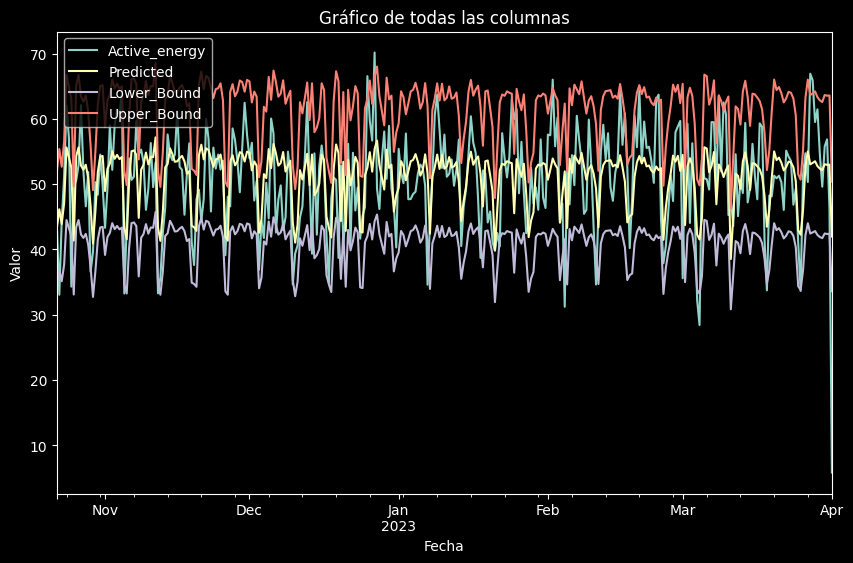

In [95]:
# # Graficar todas las columnas de combined_df
# combined_df.plot(subplots=True, figsize=(10, 10))
# plt.show()

combined_df.plot(figsize=(10, 6))
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Gráfico de todas las columnas')
plt.legend(loc='upper left')
plt.show()



In [86]:
importances = rfr.feature_importances_

# Si tienes los nombres de las características, es útil usarlos para hacer los resultados más interpretables
feature_names = train_feature.columns

# Creamos un DataFrame para visualizar mejor las importancias
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenamos el DataFrame basado en la importancia de manera descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostramos el DataFrame
feature_importance_df.head(10)


,Feature,Importance
2,L1,0.757422
3,L2,0.083878
15,L14,0.048317
4,L3,0.009659
5,L4,0.006833
29,L28,0.006134
6,L5,0.004343
14,L13,0.003015
56,L26_diff,0.002835
9,L8,0.002597


In [189]:
# # Graficar las importancias
# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
# plt.show()

### Calibración parametros Random Forest

In [ ]:
# Crear el DataFrame vacío
calibracion_modelo = pd.DataFrame(columns=['Modelo', 'Cliente', 'Parametros', 'MSE', 'MAE', 'RMSE', 'MAPE', 'R2'])

In [107]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Definir el scorer utilizando la función de MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [109]:
param_grid = {
    'n_estimators': [100,300,500],
    'max_depth': [10, 20, 30, None],  # None significa que los árboles pueden crecer tanto como sea necesario
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]  # Si se debe utilizar bootstrap para construir los árboles
}

# Creamos el modelo base con 500 árboles y uso de todos los núcleos disponibles
rfr = RandomForestRegressor()

# Configuración del GridSearchCV con el scorer de MAPE
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, scoring=mape_scorer, n_jobs=-1, verbose=2)

# Ajuste del GridSearchCV
grid_search.fit(train_feature, train_target)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\johan\anaconda3\envs\Python_3_12\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
401 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\johan\anaconda3\envs\Python_3_12\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\johan\anaconda3\envs\Python_3_12\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\johan\anaconda3\envs\Python_3_12\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_pa

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [112]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [113]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']MSE= grid_search.cv_results_['mean_test_mse'],
MAE= grid_search.cv_results_['mean_test_mae'],
RMSE= grid_search.cv_results_['mean_test_rmse'],
MAPE=grid_search.cv_results_['mean_test_mape'],
R2= grid_search.cv_results_['mean_test_r2']


# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: -17.029501 using {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


KeyError: 'mean_test_mse'

In [211]:
# Seleccionar el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
fcst = best_model.predict(test_feature)

In [212]:
evaluacion_metrica(test_target,fcst)

Evaluation metric results:-
MSE is : 45.37574437104529
MAE is : 5.202448183317379
RMSE is : 6.736152044828359
MAPE is : 12.696290164307891
R2 is : 0.25746243905542887



### Calibración parametros Random Forest

In [214]:
# Define la cuadrícula de búsqueda con los parámetros a optimizar
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],  # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'subsample': [0.8, 0.9, 1.0],  # Proporción de muestras usadas para ajustar cada árbol
    'colsample_bytree': [0.8, 0.9, 1.0],  # Proporción de características usadas para ajustar cada árbol
    'gamma': [0, 0.1, 0.2],  # Mínima reducción de pérdida requerida para dividir un nodo
}

# Crear el modelo base
xgb_base = XGBRegressor()

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid, scoring=mape_scorer, cv=3, n_jobs=-1, verbose=2)

# Ajustar el GridSearchCV
grid_search.fit(train_feature, train_target)

# Obtener los mejores parámetros
best_params = grid_search.best_params_




Fitting 3 folds for each of 972 candidates, totalling 2916 fits


In [217]:
best_params

{'colsample_bytree': 0.9,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

In [215]:
# Entrenar un nuevo modelo con los mejores parámetros encontrados
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(train_feature, train_target)

# Hacer predicciones
predictions = best_xgb_model.predict(test_feature)


In [216]:
evaluacion_metrica(test_target,predictions)

Evaluation metric results:-
MSE is : 44.83006530708753
MAE is : 5.220513071922256
RMSE is : 6.6955257677860915
MAPE is : 12.549855014179778
R2 is : 0.2663920380477105



## Generación Amonalias

In [97]:
#Umbral de detección de anomalias
upper_bound = (fcst*1.2)
lower_bound = (fcst*0.8)


In [93]:
# Convertir las predicciones y los intervalos de confianza en DataFrames con el mismo índice que test_feature
fcst_df = pd.DataFrame(fcst, index=test_target.index, columns=['Predicted'])
lower_bound_df = pd.DataFrame(lower_bound, index=test_feature.index, columns=['Lower_Bound'])
upper_bound_df = pd.DataFrame(upper_bound, index=test_feature.index, columns=['Upper_Bound'])

# Combinar test_feature, fcst_df, lower_bound_df y upper_bound_df en un solo DataFrame
combined_df = pd.concat([test_target, fcst_df, lower_bound_df, upper_bound_df], axis=1)
combined_df['anomalias'] = ((combined_df['Active_energy'] > combined_df['Upper_Bound']) |
                            (combined_df['Active_energy'] < combined_df['Lower_Bound']))

# Imprimir el DataFrame resultante
combined_df.head(5)


,Active_energy,Predicted,Lower_Bound,Upper_Bound,anomalias
Fecha,,,,,
2022-10-22 00:00:00,43.452680,43.339420,34.671536,52.007304,False
2022-10-22 12:00:00,33.054786,46.149559,36.919648,55.379471,True
2022-10-23 00:00:00,44.379023,43.894218,35.115374,52.673061,False
2022-10-23 12:00:00,51.204228,47.088019,37.670415,56.505623,False
2022-10-24 00:00:00,62.034365,55.623018,44.498415,66.747622,False


In [94]:
resumen_anomalias = combined_df['anomalias'].value_counts()
resumen_anomalias

anomalias
False    286
True      37
Name: count, dtype: int64

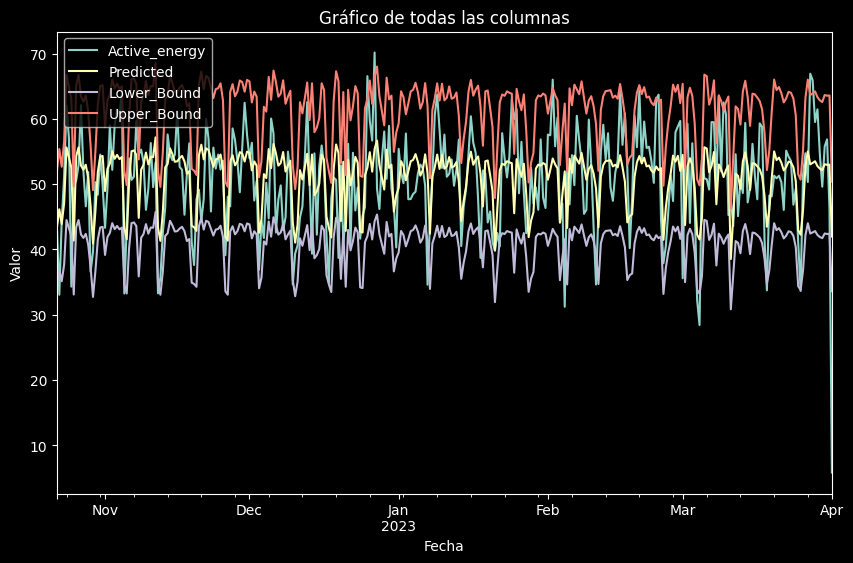

In [95]:
# # Graficar todas las columnas de combined_df
# combined_df.plot(subplots=True, figsize=(10, 10))
# plt.show()

combined_df.plot(figsize=(10, 6))
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Gráfico de todas las columnas')
plt.legend(loc='upper left')
plt.show()

